In [6]:
import diffrax
import jax
import jax.numpy as jnp
import numpy as np
from jax import random

import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

from pde_opt.numerics.domains import Domain
from pde_opt.numerics.equations.cahn_hilliard import CahnHilliard2DPeriodic
from pde_opt.numerics.solvers import SemiImplicitFourierSpectral

In [2]:

Nx, Ny = 256, 256
Lx = 0.01 * Nx
Ly = 0.01 * Ny
domain = Domain((Nx, Ny), ((-Lx / 2, Lx / 2), (-Ly / 2, Ly / 2)), "dimensionless")

t_start = 0.0
t_final = 0.2
dt = 0.000001

ts_save = jnp.linspace(t_start, t_final, 200)

kappa = 0.002




In [3]:
eq = CahnHilliard2DPeriodic(
    domain,
    kappa,
    lambda c: jnp.log(c / (1.0 - c)) + 3.0 * (1.0 - 2.0 * c),
    lambda c: (1.0 - c) * c,
    derivs="fd"
)

solver = SemiImplicitFourierSpectral(0.5, eq.fourier_symbol, eq.fft, eq.ifft)



In [4]:
key = random.PRNGKey(0)
u0 = 0.5 * jnp.ones((Nx, Ny)) + 0.01 * random.normal(key, (Nx, Ny))

solution = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.rhs(y, t))),
    solver,
    t0=t_start,
    t1=t_final,
    dt0=dt,
    y0=u0,
    # stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-6),
    saveat=diffrax.SaveAt(ts=ts_save),
    max_steps=1000000,
)

print(solution.stats)

print(jnp.mean(solution.ys[0]))
print(jnp.mean(solution.ys[-1]))

{'max_steps': 1000000, 'num_accepted_steps': Array(200269, dtype=int32, weak_type=True), 'num_rejected_steps': Array(0, dtype=int32, weak_type=True), 'num_steps': Array(200269, dtype=int32, weak_type=True)}
0.4999641
0.49986264


In [8]:
solution.ys[0].shape

(256, 256)

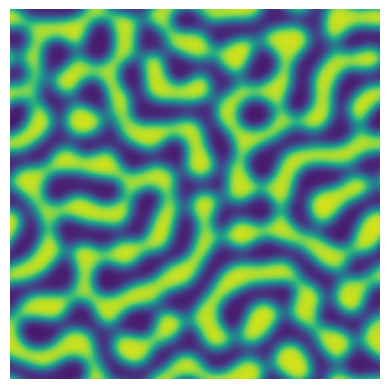

In [23]:
plt.imshow(solution.ys[75], vmin=0.0, vmax=1.0)
plt.axis('off')
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))

ims = []
for i in range(0, len(solution.ys), 2):
    im = ax.imshow(solution.ys[i], animated=True, cmap='RdBu', 
                   vmin=0.0, vmax=1.0,
                   extent=[domain.box[0][0], domain.box[0][1], 
                          domain.box[1][0], domain.box[1][1]])
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)

plt.title('Cahn-Hilliard Evolution')
plt.xlabel('x')
plt.ylabel('y')

plt.close()

HTML(ani.to_jshtml())
